### 코렙에서 한글 사용

In [ ]:
!apt -qq -y install fonts-nanum
 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
^C


### 구글드라이브 연동

In [ ]:
# 구글드라이브 연동
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# 구글 드라이브 파일 확인
!ls '/gdrive/My Drive/temp/'

# 반복되는 드라이브 경로 변수화
drive_path = '/gdrive/My Drive/temp/'

### 사전점검


In [41]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7546976713978140254, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11345264640
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2867758243636117003
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [1]:
import tensorflow as tf
from tensorflow import keras
tf.__version__, keras.__version__

('2.6.0', '2.6.0')

In [2]:
# 분산전략 정의
mirrored_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('장치의 수:', mirrored_strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
장치의 수: 1


In [ ]:
# with mirrored_strategy.scope():
#  model = ?

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

from numpy import array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding

In [ ]:
# Sequential 사용한 모델
model = keras.models.Sequential([
          keras.layers.Dense(200, activation='relu', input_shape=(28, 28, 1)),
          keras.layers.Flatten(),
          keras.layers.Dense(150, activation='relu'),
          keras.layers.Dense(10, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 28, 28, 200)       400       
_________________________________________________________________
flatten (Flatten)            (None, 156800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               23520150  
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1510      
Total params: 23,522,060
Trainable params: 23,522,060
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 함수형 API를 사용한 모델
input_layer = keras.layers.Input(shape=(28, 28, 1))
x = keras.layers.Flatten()(input_layer)

x = keras.layers.Dense(units=200, activation='relu')(x)
x = keras.layers.Dense(units=150)(x)
x = keras.layers.Activation('relu')(x)

ouput_layer = keras.layers.Dense(units=10, activation='softmax')(x)
model = keras.Model(input_layer, ouput_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               157000    
_________________________________________________________________
dense_4 (Dense)              (None, 150)               30150     
_________________________________________________________________
activation (Activation)      (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1510      
Total params: 188,660
Trainable params: 188,660
Non-trainable params: 0
_______________________________________________________

In [4]:
np.random.seed(42)
tf.random.set_seed(42)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### AE

In [5]:
# mnist 데이터
mnist = keras.datasets.mnist
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1) / 255.
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1) / 255.
X_train.shape, X_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [7]:
# AE 모델
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
            keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
            keras.layers.MaxPooling2D(pool_size=2, padding='same'),
            keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
            keras.layers.MaxPooling2D(pool_size=2, padding='same'),
            keras.layers.Conv2D(8, 3, padding='same', strides=2, activation='relu'),
])
decoder = keras.models.Sequential([
            keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
            keras.layers.UpSampling2D(),
            keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
            keras.layers.UpSampling2D(),
            keras.layers.Conv2D(16, 3, activation='relu'),
            keras.layers.UpSampling2D(),
            keras.layers.Conv2D(1, 3, padding='same', activation='sigmoid'),
])
AE = keras.models.Sequential( [encoder, decoder] )

In [8]:
encoder.summary(), decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 8)           584       
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 O

(None, None)

In [9]:
# 학습
AE.compile(loss='binary_crossentropy', optimizer='adam')
history = AE.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

Epoch 1/50
469/469 [==============================] - 36s 13ms/step - loss: 0.2093 - val_loss: 0.1395
Epoch 2/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1271 - val_loss: 0.1174
Epoch 3/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1149 - val_loss: 0.1112
Epoch 4/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1091 - val_loss: 0.1066
Epoch 5/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1055 - val_loss: 0.1028
Epoch 6/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1028 - val_loss: 0.1010
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 0.1008 - val_loss: 0.0986
Epoch 8/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0991 - val_loss: 0.0974
Epoch 9/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0978 - val_loss: 0.0959
Epoch 10/50
469/469 [==============================] - 5s 11ms/step - loss: 0.0967 - val_l

In [10]:
ae_imgs = AE.predict(X_test)

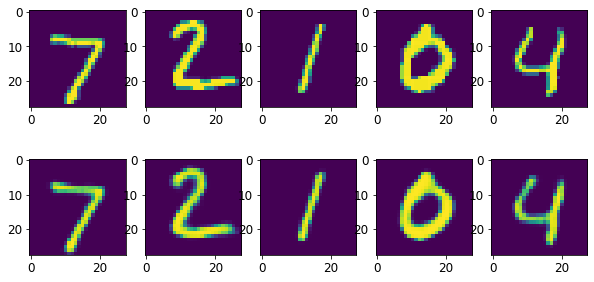

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
  axes[0, i].imshow(X_test[i].reshape(28, 28))
  axes[1, i].imshow(ae_imgs[i].reshape(28, 28))

# 생성적 적대 신경망 (Generative Adversarial Networks, gan)

2014년에 이안 굿펠로우에 의해 발표된 이론으로
서로 경쟁하는 두 개의 신경 네크워크 시스템으로 
구현하는 학습방법


* 동시에 두 개의 모델을 훈련하는 머신러닝의 한 종류
* 생성자(generator)는 가짜 데이터를 생성하도록 훈련
* 판별자(disriminator)는 실제 샘플과 가짜 샘플을 구분하도록 훈련

- 지폐위조범(Generator)은 경찰을 최대한 열심히 속이려고 하고 다른 한편에서는 경찰(Discriminator)이 이렇게 위조된 지폐를 진짜와 감별하려고(Classify) 노력


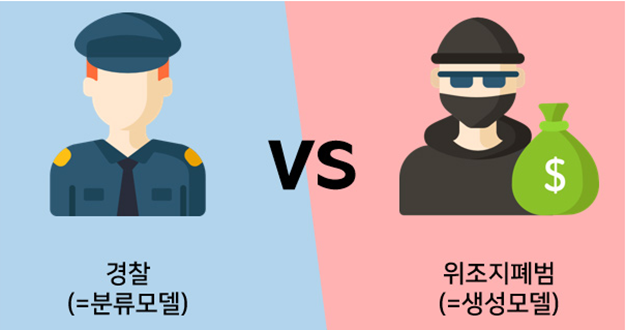

알려진 GAN 활용 사례


* [GAN을 통해 합성한 오바마 전 미국 대통령의 연설 영상](https://www.theverge.com/platform/amp/2017/7/12/15957844/ai-fake-video-audio-speech-obama)

<center>
 <img src="https://cdn.vox-cdn.com/thumbor/fzutvP17SW72ipoLfvtgF39pssc=/0x0:550x358/1400x933/filters:focal(231x135:319x223):no_upscale()/cdn.vox-cdn.com/uploads/chorus_image/image/55680261/fake_obamas.0.gif" alt="오바마 연설" width="60%" />

</center>

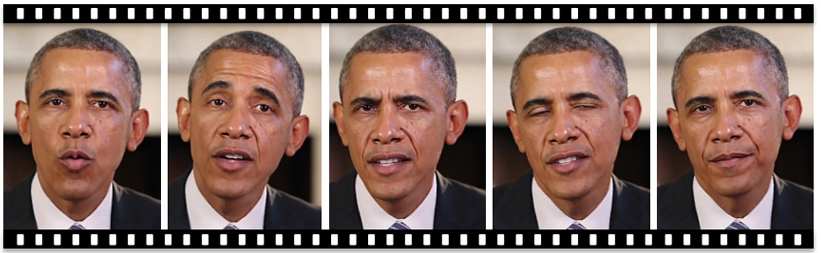

* [페이스북의 real-eye-opener](https://techcrunch.com/2018/06/16/facebooks-new-ai-research-is-a-real-eye-opener/)

<center>
 <img src="https://techcrunch.com/wp-content/uploads/2018/06/GAN-fails.jpg?resize=680,677" alt="real-eye-opener" width="60%" />

</center>

* [MIT에서 개발한  RF-Pose (동작을 예측/재현하는 기술)](https://news.mit.edu/2018/artificial-intelligence-senses-people-through-walls-0612)

<center>
 <img src="https://news.mit.edu/sites/default/files/styles/news_article__image_gallery/public/images/201806/Mingmin-RF-Pose-MIT-CSAIL-00.png?itok=l6s02yGL" alt="RF-Pose" width="60%" />

</center>

GAN의 종류

- Deep Convolutional GAN(DCGAN)
- Conditional GAN
- Info GAN
- Wasserstein GAN(WGAN)
- Attention GAN
- cycle gan
- Progressive GAN(PGGAN)
- Style GAN

> 아직 활발히 연구되는 분야이고 매년 수많은 변종 모델이 만들어짐

GAN 훈련의 어려움

- 모드붕괴(mode collapse) : GAN 훈련의 경우 생성자의 출력 다양성이 줄어듦
 - 0~9 숫자 판별 생성에 한 숫자(8)를 잃어버리는 경우

- 느린 수렴

- 과인 일반화(overgeneralization) : 존재하지 않는 잠재적 데이터 샘플이 발생하는 경우
 - 하나의 몸통에 머리가 여러 개인 소
 - 과도하게 일반화 되어 실제 존재하지 않는 것을 학습할 때 발생



해결책

- 신경망 깊이 늘리기

- 게임 설정 바꾸기 : 종료 규칙과 승리 지표

- 여러 훈련 기법
 - 입력 정규화
 - 그레이디언트에 벌칙 부과
 - 판별자 훈련 증가
 - 희소한 그레이디언트 회피
 - 간접적이고 잡음이 있는 레이블로 변경

## Simple GAN

- 생성자 : 랜덤한 분포(가우시안 분포)를 입력받아 이미지와 같은 데이터를 출력
- 판별자 : 생성자에서 얻은 가짜 이미지나 훈련 세트에서 추출한 진짜 이미지를 입력으로 받아 입력된 이미지가 가짜인지 진짜인지 구분



<center>
 <img src="https://sigmoidal.io/wp-content/uploads/2017/09/generator_and_discriminator1.png.webp" alt="generator_and_discriminator" width="80%" />

</center>

각 훈련 반복 2단계

- 목표가 다른 두 네트워크의 훈련은 일반적인 신경망과 다름
1. 판별자를 훈련
 - 훈련 세트에서 실제 이미지 배치를 샘플링하고 생성자에서 생성한 동일한 수의 가짜 이미지를 합침
 - 가짜 이미지의 레이블은 0으로 세팅하고 진짜 이미지는 1로 세팅 (이진분류)
 - 역전파는 판별자의 가중치만 최적화

2. 생성자를 훈련
 - 생성자를 사용해 다른 가짜 이미지 배치를 만듦
 - 다시 판별자를 사용해 이미지 가짜 여부를 판별
 - 이번에는 배치에 진짜 이미지를 추가하지 않고 레이블을 모두 1(진짜)로 세팅 -> 판별자가 진짜라고 (잘못) 믿을 이미지를 만들어야 함
 - 이 단계 동안에는 판별자의 가중치를 동결하는 것이 중요 -> 역전파는 생성자의 가중치만 최적화

### GAN 연습 01

Let's use MNIST:

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
X_train.shape, X_valid.shape

4431872/4422102 [==============================] - 0s 0us/step


((55000, 28, 28), (5000, 28, 28))

패션 이미지 생성

In [13]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

* 판별자는 일반적인 이진 분류기
* 생성자와 판별자가 연결된 전체 gan 모델

In [14]:
# gan 모델
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
            keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
            keras.layers.Dense(150, activation='selu'),
            keras.layers.Dense(28 * 28, activation='sigmoid'),
            keras.layers.Reshape([28, 28])            
])
discriminator = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[28, 28]),
            keras.layers.Dense(150, activation='selu'),
            keras.layers.Dense(100, activation='selu'),
            keras.layers.Dense(1, activation='sigmoid'),
])
gan = keras.models.Sequential( [generator, discriminator] )

In [15]:
generator.summary(), discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 136,634
Trainable params: 136,634
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
__________________________

(None, None)

* gan 모델도 이진 분류기 이므로 'binary_crossentropy'를 손실함수로 사용
* gan 모델을 컴파일 할 때는 판별자를 훈련하면 안됨
 - 판별자를 개별로 훈련할 때는 훈련이 가능

In [17]:
# 학습 설정
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

* 일반적인 반복 훈련이 아니기 때문에 fit() 을 사용할 수 없음
* 훈련 반복문을 별도 구현

In [19]:
# 이미지를 순회하는 dataset 준비
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [20]:
gan.layers

In [21]:
# 훈련 설정
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
  generator, discriminator = gan.layers
  for epoch in range(n_epochs):
    print(f'Epoch: {epoch} / {n_epochs}')
    for X_batch in dataset:
      # 1. 판별자 훈련
      noise = tf.random.normal(shape=[batch_size, codings_size])
      gen_imgs = generator(noise)
      X_fake_real = tf.concat([gen_imgs, X_batch], axis=0)
      y_fake_real = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
      discriminator.trainable = True
      discriminator.train_on_batch(X_fake_real, y_fake_real)

      # 2. 생성자 훈련
      noise = tf.random.normal(shape=[batch_size, codings_size])
      y_fake = tf.constant([[1.]] * batch_size)
      discriminator.trainable = False
      gan.train_on_batch(noise, y_fake)

    plot_multiple_images(gen_imgs, 8)
    plt.show()
  

Epoch: 0 / 1


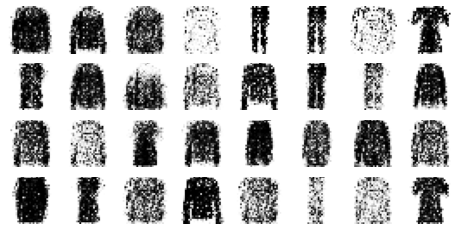

In [22]:
# 모델 훈련
train_gan(gan, dataset, batch_size, codings_size, 1)

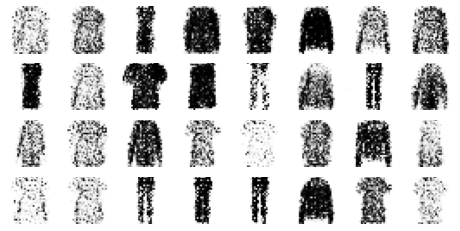

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
gen_imgs = generator(noise)
plot_multiple_images(gen_imgs, 8)
plt.show()

In [ ]:
# train_gan(gan, dataset, batch_size, codings_size, 50)

## DCGAN(Deep Convolutional GAN, 심층합성곱GAN)

- 합성곱(CNN) 기반으로 한 GAN
- 상당히 의미 있는 잠재 표현 학습 가능

논문 제안 가이드
- 각 레이어에 Convolution layer를 사용한다. 
- 단, CNN과 달리 Pooling layer, Fully connected layer는 사용하지 않는다. 
- 레이어 계산 결과에 Batch Normalization를 사용한다. 
- 활성 함수(Activation function)으로 ReLU 대신 LeakyReLU를 사용한다.

### GAN 연습 02

In [32]:
# DCGAN 모델 생성
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

# 생성자는 크기 100의 코딩을 받아 6272차원(7*7*128)로 투영 
# 이 결과를 7*7*128크기의 텐서로 바꿈
# 이 텐서는 배치 정규화를 거쳐 
# 스트라이드가 2인 다른 전치 합성곱 층에 주입
#  7*7에서 14*14로 업샘플링되고 깊이는 128에서 64로 감소
# 이 결과 다시 배치 정규화 층을 지나서 
# 스트라이드가 2인 다른 전치 합성곱 층에 주입
#  여기서 14*14에서 28*28로 업샘플링되고 깊이는 64에서 1로 감소
#  이 층은 tanh 활성화 함수를 사용하므로 출력 범위가 -1에서 1사이
#  이 때문에 이 GAN 훈련하기 전에 훈련 세트를 동일한 범위로 스케일 조정
#  또한 크기를 바꾸고 채널 차원을 추가
#     X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # 크기변경과 스케일 조정
generator = keras.models.Sequential([
            keras.layers.Dense(7*7*128, input_shape=[codings_size]),
            keras.layers.Reshape([7, 7, 128]), 
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2,
                                         padding='same', activation='selu'),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2,
                                         padding='same', activation='tanh'),
])

# 판별자는 이진 분류를 위한 일반 CNN과 비슷
#  다만 이미지를 다운샘플링하기 위해 최대 폴링 층을 사용하지 않고
#  스트라이드 합성곱( strides=2)을 사용과 LeakyReLU 사용
discriminator = keras.models.Sequential([
                keras.layers.Conv2D(64, kernel_size=5, strides=2,
                                    padding='same', activation=keras.layers.LeakyReLU(0.2),
                                    input_shape=[28, 28, 1]),
                keras.layers.Dropout(0.5),
                keras.layers.Conv2D(128, kernel_size=5, strides=2,
                                    padding='same', activation=keras.layers.LeakyReLU(0.2)),
                keras.layers.Dropout(0.5),
                keras.layers.Flatten(),
                keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

In [33]:
generator.summary(), discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 1)         1601      
Total params: 840,705
Trainable params: 840,321
Non-trainable params: 384
_____________________________________________

(None, None)

In [34]:
# 학습 설정
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [36]:
# X_train 크기변경과 스케일 조정
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # 크기변경과 스케일 조정

In [37]:
# 이미지를 순회하는 dataset 준비
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch: 0 / 1


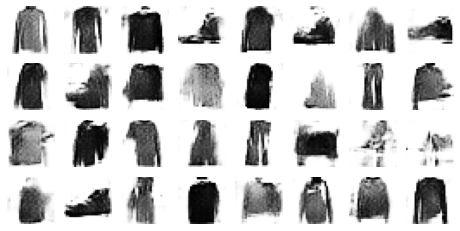

In [38]:
# 모델 훈련
train_gan(gan, dataset, batch_size, codings_size, 1)

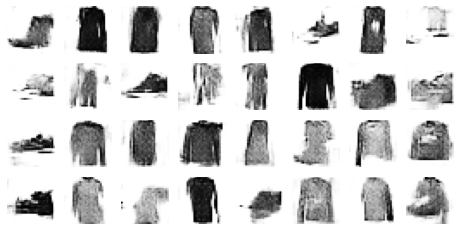

In [39]:
np.random.seed(42)
tf.random.set_seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
gen_imgs = generator(noise)
plot_multiple_images(gen_imgs, 8)
plt.show()